## kNN From Scratch With MNST dataset Using Python

신경망(Neural Network) 알고리즘을 구현해보기에 앞서, 지도학습(supervised learning)에서 활용되는 가장 단순한 종류의 알고리즘인 **kNN**을 이해하고 구현해보도록 하겠습니다.

kNN은 **k-Nearest Neighbors**의 약자이며, 쉽게 설명하면 테스트 데이터가 들어올 경우, 전체 학습 데이터와 신규 테스트 데이터 간의 거리를 구한 뒤, 그 거리가 가까운(인접한) k개의 학습 데이터를 가져와 가장 많이 존재하는 값을 테스트 데이터의 값으로 예측하는 방식을 의미합니다.

- 참고 : http://blog.naver.com/samsjang/220673340574 
![kNN_img](./img/kNN.png)

이 때 거리를 구하는 방식이 여러 가지가 있을 수 있는데, 일반적으로는 유클리디안 거리를 사용합니다.

![distance_img](./img/euclidean_distance.png)

위 그림에서 보는 바와 같이 유클리디안 거리는 좌표계에 두 점이 있을 때 두 지점의 최단거리(엄밀하게 말하면 유클리디안 좌표계에서 최단거리)를 의미합니다.

실습에 사용할 데이터는 손글씨 데이터(일명 MNIST)이며, 자료는 다음 경로에서 받으실 수 있습니다.

- Sample Dataset <-- 이 주피터노트북에서는 샘플 데이터셋으로 학습 및 테스트를 진행합니다.
    - Test Dataset (n=10)
        - https://github.com/makeyourownneuralnetwork/makeyourownneuralnetwork/blob/master/mnist_dataset/mnist_test_10.csv
    - Train Dataset (n=100)
        - https://github.com/makeyourownneuralnetwork/makeyourownneuralnetwork/blob/master/mnist_dataset/mnist_train_100.csv

- Full Dataset
    - Test Dataset
        - https://pjreddie.com/media/files/mnist_train.csv
    - Train Dataset 
        - https://pjreddie.com/media/files/mnist_test.csv

그럼 실제로 kNN 알고리즘을 구현해보도록 하겠습니다.

In [1]:
# 먼저 pandas library 의 read_csv를 사용하여 csv 형식의 test data set 과 train data set 을 불러옵니다.

import pandas as pd

In [2]:
# 손글씨 데이터는 mnist_train.csv 와 mnist_test.csv 로 이루어져 있습니다.
# Github에 jupyter notebook을 올려 공유하기 위해 용량이 작은 샘플 데이터로 진행하겠습니다.
# 참고로 저의 경우, 로컬에서는 Full Data 에서 샘플링하여 진행했습니다.

with open("./mnist_train_100.csv","r") as csvfile:
    train_data = pd.read_csv(csvfile, header=None)
    
with open("./mnist_test_10.csv","r") as csvfile:
    test_data = pd.read_csv(csvfile, header=None)

In [3]:
# 불러온 데이터를 살펴보겠습니다.

train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 613.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 61.4 KB


In [4]:
# 학습데이터는 총 100개, 테스트데이터는 총 10개로 이루어져 있으며, 컬럼은 총 785개입니다.

train_data.iloc[:3,:]

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_data.iloc[:3,:]

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# 학습데이터와 테스트테이터 모두 첫번째 컬럼은 라벨이고 두번째 컬럼 부터 785번째 컬럼까지가 변수로 이루어져 있는 걸 확인할 수 있습니다.
# 분석상 용이를 위해 각 데이터셋에서 첫번째 컬럼은 라벨로 두번째 컬럼부터는 변수 데이터로 분리해 저장합니다.

test_labels = test_data.iloc[:,0]
test_data = test_data.iloc[:,1:]
train_labels = train_data.iloc[:,0]
train_data = train_data.iloc[:,1:]

In [7]:
# 모델링 이후 정확도를 측정하기 위해 사용할 변수값들도 미리 선언해두도록 하겠습니다.

accu_k = []
accu_rate = []
accuracy = []
accuracy = pd.DataFrame(accuracy)

In [8]:
# 본격적으로, KNN 알고리즘을 직접 구현해보도록 하겠습니다.
# (기본적인 알고리즘 구현이 목적으로 정규화와 크로스 벨리데이션 등의 작업은 생략합니다.)

# 모델 재사용의 용이성 확보를 위해 함수로 만들도록 하겠습니다.
# KNN 모델링을 위해, 학습데이터셋, 테스트데이터셋, 학습데이터라벨, 테스트데이터라벨 그리고 K값을 변수로 입력받습니다.

def knn(train_data, test_data, train_labels, test_labels, k):
    est_labels = [] # 예측한 값들을 최종적으로 저장하기 위한 변수 입니다.
    accuracy = [] # 모델의 예측 정확도를 저장하기 위한 변수 입니다.
    accuracy = pd.DataFrame(accuracy)
    
    for i in range(len(test_data)):
        x = []
        dist = []
        
        # 각종 필요한 변수들을 미리 선언해둡니다.
        dist_label = [] # 테스트 데이터와 학습 데이터 간의 거리를 저장하기 위한 변수입니다.
        dist_label = pd.DataFrame(dist_label)
        top_knn = [] # 인근 값 중 제일 빈번하게 나온 값을 저장하기 위한 변수입니다.
        est_label = [] # 각 테스트 데이터별로 예측한 값을 임시로 저장해두기 위한 변수입니다.
        
        # 각 테스트 데이터별로 KNN 알고리즘으로 라벨을 예측합니다.
        for j in range(len(train_data)):
            x = ((test_data.iloc[i,:] - train_data.iloc[j,:] ) ** 2).sum() ** 0.5 # 유클리디안 거리를 계산합니다.
            dist.append(x) # 테스트데이터와 학습데이터 간 유클리디안 거리를 구하여 dist 변수에 추가합니다.
            
        dist_label["dist"] = dist
        dist_label["label"] = train_labels
        dist_label.sort_values(['dist'], inplace=True) # 거리를 기준으로 오름차순 정렬합니다.
        top_knn = dist_label[:k]['label'] # 각 테스트 데이터로부터 거리가 제일 가까운 k개의 학습 데이터를 찾습니다.
        est_label = top_knn.value_counts().index[0] # k개의 학습 데이터 중 가장 빈도가 많은 라벨을 구합니다.
        est_labels.append(est_label) # 각 테스트 데이터로부터 구한 label을 est_labels 변수에 추가합니다.
    
    test_est = []
    test_est = pd.DataFrame(test_est)
    test_est["test_labels"] = test_labels
    test_est["estimated_labels"] = est_labels # 정확도 비교를 용이하게 하기 위해 테스트 데이터의 실제 라벨과 예측한 라벨을 하나의 데이터프레임에 저장합니다.
    
    # 정확도를 계산합니다.
    correct = 0
    for p in range(len(test_est)):
        if test_est["test_labels"][p] == test_est["estimated_labels"][p]:
            correct += 1 # 실제 라벨과 예측 라벨이 같은 것의 갯수를 셉니다.
            
    accuracy = (correct/float(len(test_est))) * 100.0 # 맞춘 갯수를 전체 갯수로 나누어 정확도를 구합니다.      
    print("k=%d, accuracy=%.2f%%" % (k, accuracy))       
    
    return test_est, accuracy

In [9]:
# 작성한 knn 알고리즘으로 테스트 데이터의 라벨을 예측해보겠습니다.
# k는 임의로 3을 지정하여 보도록 하겠습니다.

test_est, accuracy = knn(train_data, test_data, train_labels, test_labels, k=3)

k=3, accuracy=60.00%


In [10]:
#실제 라벨과 예측 라벨 값을 눈으로 확인해보겠습니다.

test_est

,test_labels,estimated_labels
0,7,7
1,2,3
2,1,1
3,0,0
4,4,4
5,1,1
6,4,7
7,9,4
8,5,6
9,9,9


Estimated_labels= 4


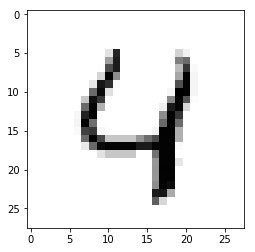

In [ ]:
# 테스트 이미지와 예측한 글씨를 확인해보도록 하겠습니다.

import numpy as np
import matplotlib.pyplot
%matplotlib inline

i = 4 # 몇 번째 데이터를 볼 건지 정합니다. 

image_array = np.asfarray(test_data.iloc[i,:]).reshape((28,28)) # i번째 테스트 데이터를 28x28 행렬로 변경하여 저장합니다.
matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None') # 28x28 행렬을 이미지로 변환하여 그래프를 그립니다. 
print("Estimated_labels= %d" % (test_est["estimated_labels"][i])) # i번째 테스트 데이터의 예측값을 출력합니다.

In [ ]:
# 이제 가장 정확도가 높게 나오는 k 를 찾아보도록 하겠습니다.

for k in range(1, 16): 
    test_est, accuracy = knn(train_data, test_data, train_labels, test_labels, k)

k=1, accuracy=60.00%
k=2, accuracy=50.00%
k=3, accuracy=60.00%
k=4, accuracy=60.00%
k=5, accuracy=60.00%


이번에는 python library 중 **sikit-learn** 에 있는 **KNeighborsClassifier** 를 가지고 손쉽게 kNN 알고리즘 결과를 구해보도록 하겠습니다.

- 참고 : http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
model.fit(train_data, train_labels)

k = 5

# evaluate the model and update the accuracies list
score = model.score(test_data, test_labels)
print("k=%d, accuracy=%.2f%%" % (k, score * 100))
predictions = model.predict(test_data)

test_est = []
test_est = pd.DataFrame(test_est)
test_est["test_labels"] = test_labels
test_est["estimated_labels"] = predictions

In [ ]:
test_est